no avalanche distribution for 2D/d2_g20_c7_op_co
no avalanche distribution for 2D/d2_g40_c7_op_co


,dimension,grid,relax,tau,alpha,lambda,gamma1,1/gamma1,gamma2,1/gamma2,gamma3,1/gamma3
0,2,5,op co,2.28+/-0.12,2.60+/-0.24,1.93+/-0.08,1.150+/-0.019,0.718+/-0.004,0.950+/-0.030,0.744+/-0.012,0.772+/-0.019,0.91+/-0.05
0,2,5,op nco,1.13+/-0.10,0.96+/-0.08,0.91+/-0.15,1.317+/-0.026,0.6749+/-0.0022,1.24+/-0.11,0.695+/-0.017,0.92+/-0.05,0.92+/-0.06
0,2,5,cl nco,2.61+/-0.13,3.17+/-0.32,2.9+/-0.6,1.18+/-0.05,0.698+/-0.016,0.89+/-0.05,0.647+/-0.032,0.711+/-0.007,0.91+/-0.06
0,2,10,op co,2.206+/-0.006,2.165+/-0.019,1.8+/-0.4,1.219+/-0.015,0.6649+/-0.0035,1.31+/-0.12,0.519+/-0.011,1.00+/-0.06,0.97+/-0.05
0,2,10,op nco,1.915+/-0.007,1.801+/-0.011,1.29+/-0.31,1.453+/-0.012,0.6683+/-0.0015,2.44+/-0.22,0.581+/-0.006,1.61+/-0.12,0.96+/-0.04
0,2,10,cl nco,2.042+/-0.019,1.936+/-0.029,1.7+/-0.4,1.471+/-0.009,0.6646+/-0.0020,1.54+/-0.08,0.596+/-0.011,0.93+/-0.07,0.96+/-0.05
0,2,20,op nco,1.960+/-0.009,1.845+/-0.012,1.5+/-0.4,1.533+/-0.004,0.6611+/-0.0006,1.8320+/-0.0016,0.601+/-0.009,1.1956+/-0.0028,0.98+/-0.04
0,2,20,cl nco,2.0026+/-0.0033,1.924+/-0.012,1.5+/-0.4,1.491+/-0.006,0.6653+/-0.0013,1.807+/-0.022,0.585+/-0.004,1.08+/-0.04,1.01+/-0.05
0,2,40,op nco,2.0380+/-0.0022,1.962+/-0.005,1.70+/-0.08,1.5930+/-0.0012,0.6494+/-0.0011,1.902+/-0.022,0.547+/-0.009,1.194+/-0.016,0.812+/-0.005
0,2,40,cl nco,2.067+/-0.023,1.972+/-0.007,1.73+/-0.05,1.5727+/-0.0015,0.6544+/-0.0016,1.835+/-0.035,0.468+/-0.004,1.177+/-0.013,0.857+/-0.007


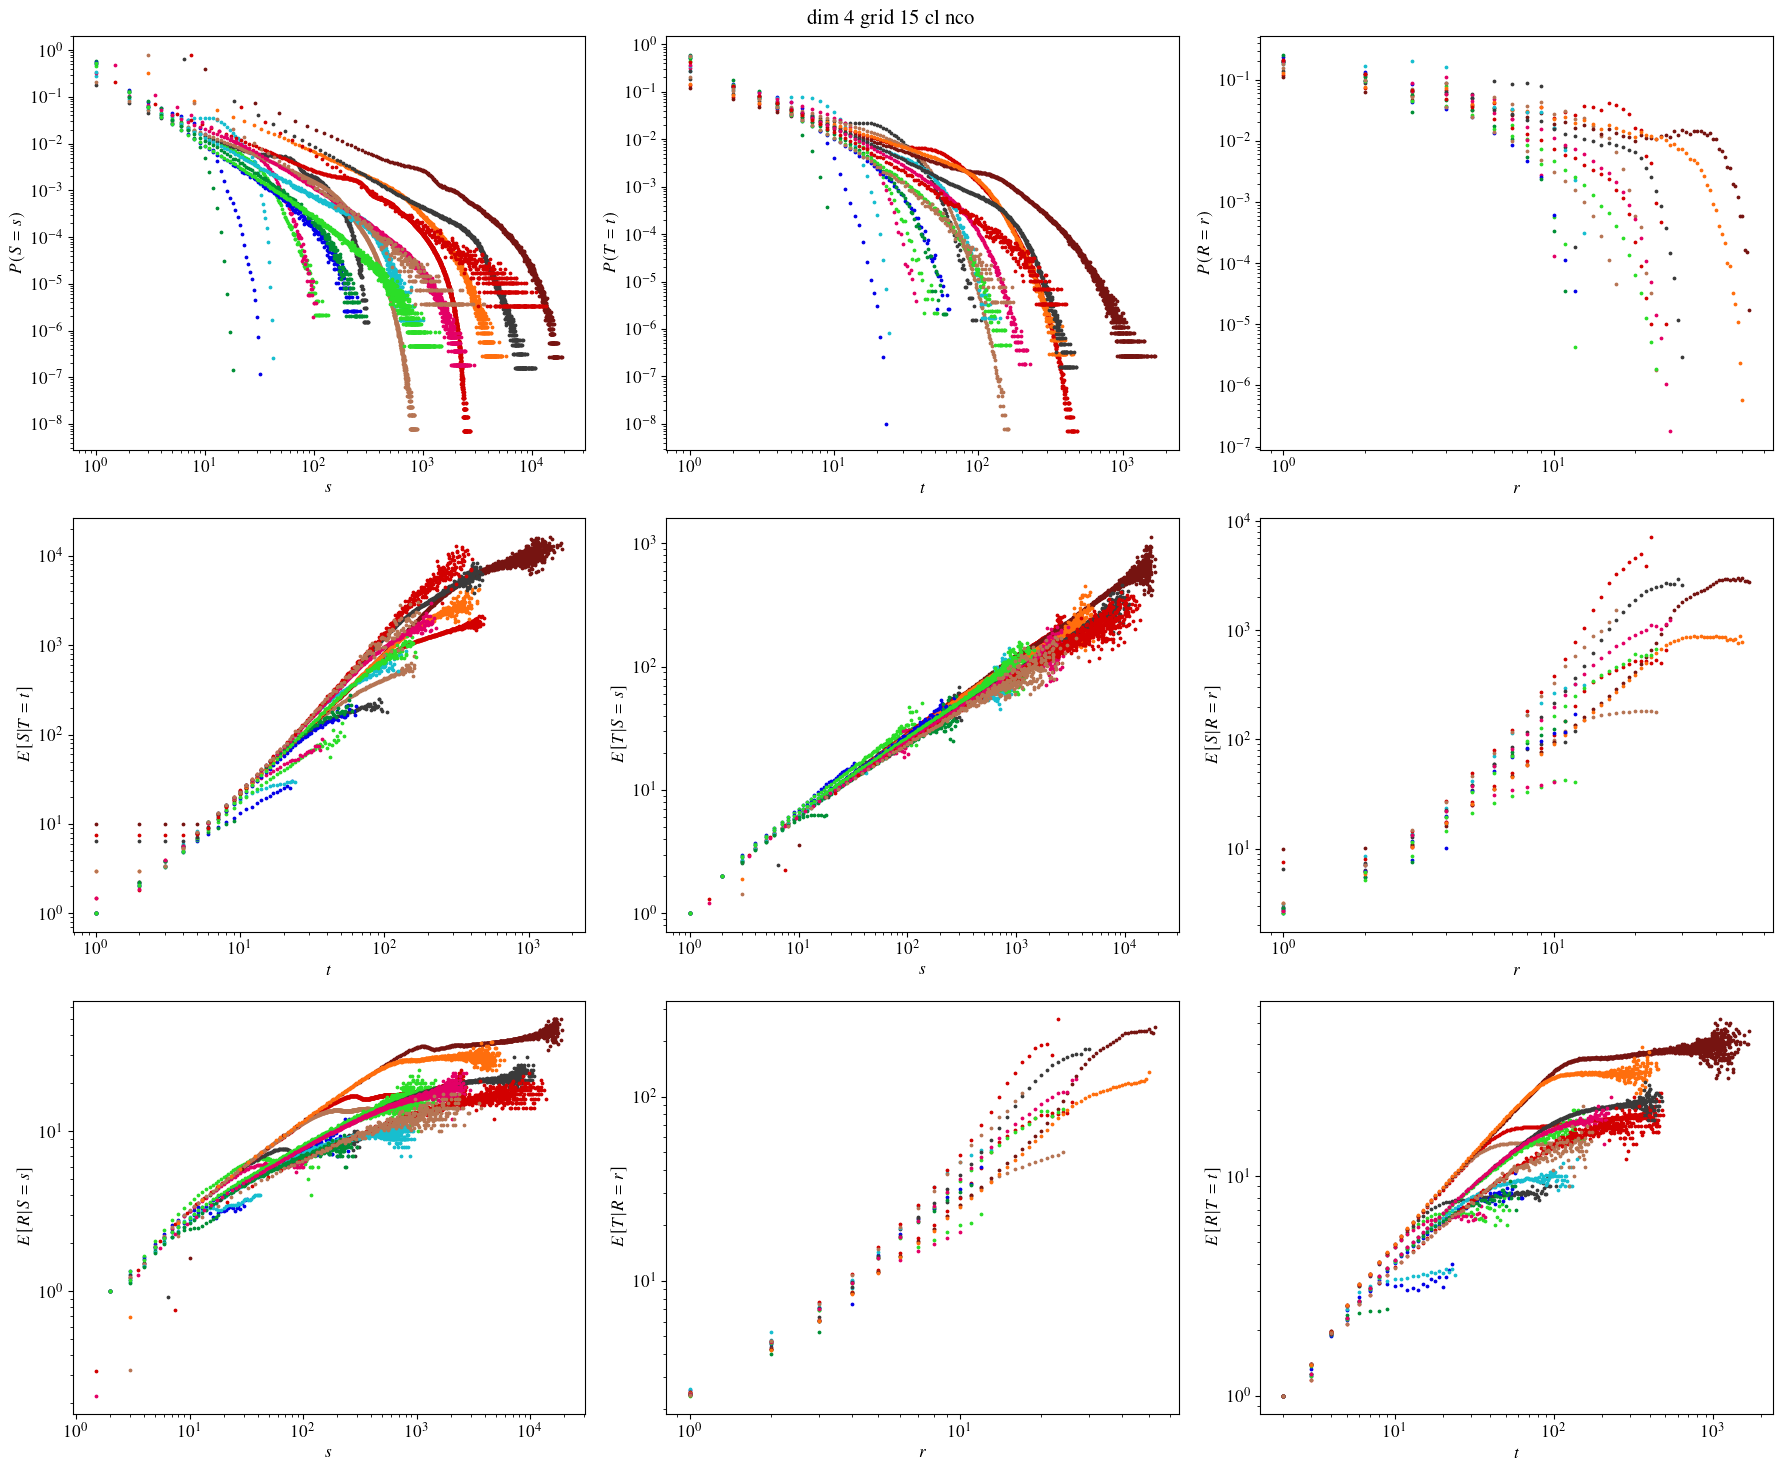

In [46]:
import matplotlib.pyplot as plt

from analysis import plot_scaling_exponents
from computation import *
import json
import pathlib
import pandas as pd

fig, ax = plt.subplots(3,3, figsize=(18, 15))
data_dir = pathlib.Path("data")
with open("scaling_exponents.json", "r") as f:
    meta = json.load(f)

# if specified, calculate scaling exponents for only one data set
do_plot = False
if isinstance(meta[0], int):
    meta = [meta[meta[0]]]
    do_plot = True

# number 7, 10 no distribution
df = pd.DataFrame()
for m in meta:
    if not (data_dir / m["path"] / "avalanche_distribution.npz").exists():
        print(f"no avalanche distribution for {m['path']}")
        continue
    (s, t, r), bins = load_3d_dist(data_dir / m["path"] / "avalanche_distribution.npz")
    fig.suptitle(m["label"])
    _df = plot_scaling_exponents(s, t, r, bins, ax, pathlib.Path(m["path"]).name,
                                m.get("limits", None), do_plot)
    df = pd.concat([df, _df])
df

In [56]:
import uncertainties as unc
df.query("grid != 5 and relax == 'cl nco'", inplace=True)
df = df.map(lambda x: "{:.2uS}".format(x) if isinstance(x, unc.core.AffineScalarFunc) else x)
df_new = df.sort_values(["dimension", "grid"]).set_index(["dimension", "grid"])
# df_new.reset_index(level='relax', inplace=True)
# df_new.drop("relax", axis=0, inplace=True)
# df_new["relax"]
# df_new.drop("relax", inplace=True)
df_new


relax         tau       alpha     lambda      gamma1  \
dimension grid                                                          
2         10    cl nco   2.042(19)   1.936(29)   1.66(40)  1.4713(87)   
          20    cl nco  2.0026(33)   1.924(12)   1.53(37)  1.4908(56)   
          40    cl nco   2.067(23)  1.9722(71)  1.725(53)  1.5727(15)   
3         10    cl nco   2.499(11)   2.556(23)   2.31(30)  1.5764(80)   
          20    cl nco  2.3827(58)   2.448(14)   2.22(17)  1.6756(31)   
4         15    cl nco   2.659(15)   2.468(37)   2.81(13)  1.7162(75)   

                  1/gamma1     gamma2    1/gamma2     gamma3    1/gamma3  
dimension grid                                                            
2         10    0.6646(20)  1.544(79)   0.596(11)  0.932(66)   0.958(47)  
          20    0.6653(13)  1.807(22)  0.5850(41)  1.075(40)   1.010(51)  
          40    0.6544(16)  1.835(35)  0.4680(40)  1.177(13)  0.8570(70)  
3         10    0.6084(28)   1.82(12)  0.4978(67)  1.228(43)   0.744(16)  
          20    0.6216(34)   1.80(11)  0.4260(29)  1.220(45)  0.7520(98)  
4         15    0.5377(89)   2.15(10)  0.3500(39)  1.338(43)  0.6214(61)